In [1]:
import glob

import pandas as pd
import warnings
warnings.simplefilter(action="ignore", category=pd.errors.PerformanceWarning)
import numpy as np

import matplotlib.pyplot as plt
import mplhep as hep
plt.rcParams.update({"figure.facecolor":  (1,1,1,0)})

from utils.analysis import Optimization

In [2]:
TAG = "abcdnet_detajj"

babies = sorted(glob.glob(f"../analysis/studies/vbsvvhjets/output_{TAG}/Run2/*.root"))
sig_babies = [baby for baby in babies if "VBSVVH" in baby]
bkg_babies = [baby for baby in babies if "VBS" not in baby and "data" not in baby]
data_babies = [baby for baby in babies if "data" in baby]
print("Signal:")
print("\n".join(sig_babies))
print("Background:")
print("\n".join(bkg_babies))
print("Data:")
print("\n".join(data_babies))

Signal:
../analysis/studies/vbsvvhjets/output_abcdnet_detajj/Run2/VBSVVH.root
Background:
../analysis/studies/vbsvvhjets/output_abcdnet_detajj/Run2/Bosons.root
../analysis/studies/vbsvvhjets/output_abcdnet_detajj/Run2/QCD.root
../analysis/studies/vbsvvhjets/output_abcdnet_detajj/Run2/SingleTop.root
../analysis/studies/vbsvvhjets/output_abcdnet_detajj/Run2/TT1L.root
../analysis/studies/vbsvvhjets/output_abcdnet_detajj/Run2/TTH.root
../analysis/studies/vbsvvhjets/output_abcdnet_detajj/Run2/TTHad.root
../analysis/studies/vbsvvhjets/output_abcdnet_detajj/Run2/TTW.root
Data:
../analysis/studies/vbsvvhjets/output_abcdnet_detajj/Run2/data.root


In [3]:
vbsvvh = Optimization(
    sig_root_files=sig_babies,
    bkg_root_files=bkg_babies,
    data_root_files=data_babies,
    ttree_name="tree",
    weight_columns=[
        "xsec_sf", 
        "pu_sf",
        "prefire_sf",
        "qcdnorm_sf"
    ]
)

vbsvvh.df["objsel"] = True
vbsvvh.df["presel"] = vbsvvh.df.eval(
    "objsel and hbbfatjet_xbb > 0.5 and ld_vqqfatjet_xwqq > 0.3 and tr_vqqfatjet_xwqq > 0.3"
)
vbsvvh.make_selection("presel")

Loading data babies: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.72it/s]


In [4]:
if TAG == "abcdnet_bdt":
    results_csv = "results_d694f3b4e326.csv"
elif TAG == "abcdnet_detajj":
    results_csv = "results_fa07fcd1b9e7.csv"
else:
    raise Exception(
        "You need make sure the results CSV is in studies/vbsvvhjets/output_{TAG} and hard-code it here"
    )

with open(results_csv) as csv:
    results_df = pd.read_csv(csv)

In [5]:
best_result = results_df[(results_df.A_pred > 0.5) & (results_df.B_data >= 4)].iloc[-1]
best_result

region_A    abcdnet_score > 0.89 and abs_deta_jj > 5.0 and...
A_sig                                                5.138901
B_sig                                                0.964857
C_sig                                                0.395753
D_sig                                                 0.32934
A_bkg                                                2.371824
B_bkg                                               11.593204
C_bkg                                               62.077116
D_bkg                                              634.939486
B_data                                                     10
C_data                                                     72
D_data                                                    677
A_pred                                               1.063516
fom                                                  4.983085
Name: 63503, dtype: object

In [6]:
cuts = best_result.region_A.split(" and ")
x_arm = cuts[0]
y_arm = cuts[1]
presel = cuts[2:]

# How to sub-divide the control regions for closure tests
if TAG == "abcdnet_bdt":
    x_mid = "abcdnet_score > 0.4"
    y_mid = "vbs_bdt_score > 0.4"
elif TAG == "abcdnet_detajj":
    x_mid = "abcdnet_score > 0.4"
    y_mid = "abs_deta_jj > 2.5"

A = " and ".join([x_arm, y_arm, *presel])
B = " and ".join([x_arm, f"(not {y_arm})", *presel])
C = " and ".join([f"(not {x_arm})", y_arm, *presel])
D = " and ".join([f"(not {x_arm})", f"(not {y_arm})", *presel])

B1 = " and ".join([x_arm, f"({y_mid}) and (not {y_arm})", *presel])
B2 = " and ".join([x_arm, f"(not {y_mid}) and (not {y_arm})", *presel])
C1 = " and ".join([f"({x_mid}) and (not {x_arm})", y_arm, *presel])
C2 = " and ".join([f"(not {x_mid}) and (not {x_arm})", y_arm, *presel])
D1 = " and ".join([f"({x_mid}) and (not {x_arm})", f"({y_mid}) and (not {y_arm})", *presel])
D2 = " and ".join([f"({x_mid}) and (not {x_arm})", f"(not {y_mid}) and (not {y_arm})", *presel])
D3 = " and ".join([f"(not {x_mid}) and (not {x_arm})", f"({y_mid}) and (not {y_arm})", *presel])
D4 = " and ".join([f"(not {x_mid}) and (not {x_arm})", f"(not {y_mid}) and (not {y_arm})", *presel])

In [217]:
import matplotlib.patches as patches

def plot_abcd_cartoon(x_arm, y_arm):
    
    fig, axes = plt.subplots()

    if TAG == "abcdnet_bdt":
        ylim = [0, 1]
    elif TAG == "abcdnet_detajj":
        ylim = [0, 10]

    axes.set_ylim(ylim)

    # Move the left and bottom spines to x = 0 and y = 0, respectively.
    axes.spines[["left", "bottom"]].set_position(("data", 0))
    # Hide the top and right spines.
    axes.spines[["top", "right"]].set_visible(False)
    axes.spines[["left", "bottom"]].set_linewidth(8)

    axes.plot(1, 0, ">k", markersize=30, clip_on=False)
    axes.plot(*ylim, "^k", markersize=30, clip_on=False)

    axes.set_xlabel("ABCDNet score", weight="bold", size=48)

    x_wp = float(x_arm.split(" > ")[-1])
    y_wp = float(y_arm.split(" > ")[-1])
    
    axes.axhline(y_wp, color="k", linewidth=8)
    axes.axvline(x_wp, color="k", linewidth=8)

    if TAG == "abcdnet_bdt":
        axes.set_ylabel("BDT score", weight="bold", size=48)
    elif TAG == "abcdnet_detajj":
        axes.set_ylabel("$|\Delta\eta_{jj}|$", weight="bold", size=48)

    centered = {"horizontalalignment": "center", "verticalalignment": "center", "size": 48, "weight": "bold"}

    axes.text((1 + x_wp)/2, (ylim[-1] + y_wp)/2, "A", **centered)
    axes.text((1 + x_wp)/2, (y_wp + 0)/2, "B", **centered)
    axes.text((0 + x_wp)/2, (ylim[-1] + y_wp)/2, "C", **centered)
    axes.text((x_wp + 0)/2, (y_wp + 0)/2, "D", **centered)

    axes.set_xticks([x_wp])
    axes.set_yticks([y_wp])
    
    # Remove all margins
    axes.margins(0)
    # Remove CMS-style ticks on top and right sides of plot
    axes.tick_params(top=False, right=False, labelsize=48, pad=12)
    axes.tick_params(top=False, right=False, which="minor")

def plot_abcd(x_arm, y_arm, x_mid=None, y_mid=None):
    
    plot_x_mid = (not x_mid is None)
    plot_xy_mid = (plot_x_mid and not y_mid is None)
    
    fig, axes = plt.subplots()

    if TAG == "abcdnet_bdt":
        ylim = [0, 1]
    elif TAG == "abcdnet_detajj":
        ylim = [0, 10]

    axes.set_ylim(ylim)

    # Move the left and bottom spines to x = 0 and y = 0, respectively.
    axes.spines[["left", "bottom"]].set_position(("data", 0))
    # Hide the top and right spines.
    axes.spines[["top", "right"]].set_visible(False)

    axes.plot(1, 0, ">k", markersize=10, clip_on=False)
    axes.plot(*ylim, "^k", markersize=10, clip_on=False)

    axes.set_xlabel("ABCDNet score")

    x_wp = float(x_arm.split(" > ")[-1])
    y_wp = float(y_arm.split(" > ")[-1])
    if plot_x_mid:
        x_md = float(x_mid.split(" > ")[-1])
    if plot_xy_mid:
        y_md = float(y_mid.split(" > ")[-1])
    
    axes.axhline(y_wp, color="k", linewidth=2)
    axes.axvline(x_wp, color="k", linewidth=2)
    if plot_x_mid:
        axes.axvline(x_md, color="grey", linewidth=2)
    if plot_xy_mid:
        axes.axhline(y_md, color="grey", linewidth=2)

    if TAG == "abcdnet_bdt":
        axes.set_ylabel("BDT score")
    elif TAG == "abcdnet_detajj":
        axes.set_ylabel("$|\Delta\eta_{jj}|$")

    centered = {"horizontalalignment": "center", "verticalalignment": "center", "size": 48}

    if plot_xy_mid:
        axes.text((1 + x_wp)/2, (ylim[-1] + y_wp)/2, "A", **centered)
        axes.text((x_wp + x_md)/2, (ylim[-1] + y_wp)/2, "C$_1$", **centered)
        axes.text((x_md + 0)/2, (ylim[-1] + y_wp)/2, "C$_2$", **centered)

        axes.text((1 + x_wp)/2, (y_wp + y_md)/2, "B$_1$", **centered)
        axes.text((x_wp + x_md)/2, (y_wp + y_md)/2, "D$_1$", **centered)
        axes.text((x_md + 0)/2, (y_wp + y_md)/2, "D$_3$", **centered)

        axes.text((1 + x_wp)/2, (y_md + 0)/2, "B$_2$", **centered)
        axes.text((x_wp + x_md)/2, (y_md + 0)/2, "D$_2$", **centered)
        axes.text((x_md + 0)/2, (y_md + 0)/2, "D$_4$", **centered)
    elif plot_x_mid:
        axes.text((1 + x_wp)/2, (ylim[-1] + y_wp)/2, "A", **centered)
        axes.text((x_wp + x_md)/2, (ylim[-1] + y_wp)/2, "C$_1$", **centered)
        axes.text((x_md + 0)/2, (ylim[-1] + y_wp)/2, "C$_2$", **centered)

        axes.text((1 + x_wp)/2, (y_wp + 0)/2, "B", **centered)
        axes.text((x_wp + x_md)/2, (y_wp + 0)/2, "D$_1$", **centered)
        axes.text((x_md + 0)/2, (y_wp + 0)/2, "D$_2$", **centered)
    else:
        axes.text((1 + x_wp)/2, (ylim[-1] + y_wp)/2, "A", **centered)
        axes.text((1 + x_wp)/2, (y_wp + 0)/2, "B", **centered)
        axes.text((0 + x_wp)/2, (ylim[-1] + y_wp)/2, "C", **centered)
        axes.text((x_wp + 0)/2, (y_wp + 0)/2, "D", **centered)

    if plot_xy_mid:
        axes.set_xticks([x_md, x_wp])
        axes.set_yticks([y_md, y_wp])
    elif plot_x_mid:
        axes.set_xticks([x_md, x_wp])
        axes.set_yticks([y_wp])
    else:
        axes.set_xticks([x_wp])
        axes.set_yticks([y_wp])
    
    # Remove all margins
    axes.margins(0)
    # Remove CMS-style ticks on top and right sides of plot
    axes.tick_params(top=False, right=False, labelsize=24)
    axes.tick_params(top=False, right=False, which="minor")
    
    # Create a Rectangle patch for each region
    A_rect = patches.Rectangle(
        (x_wp, y_wp), (1 - x_wp), (ylim[-1] - y_wp), 
        linewidth=0, facecolor="#61D836", alpha=0.25
    )
    B_rect = patches.Rectangle(
        (x_wp, 0), (1 - x_wp), (y_wp), 
        linewidth=0, facecolor="#56C1FF", alpha=0.25
    )
    C_rect = patches.Rectangle(
        (0, y_wp), (x_wp), (ylim[-1] - y_wp), 
        linewidth=0, facecolor="#B51700", alpha=0.25
    )
    D_rect = patches.Rectangle(
        (0, 0), (x_wp), (y_wp), 
        linewidth=0, facecolor="#FFD932", alpha=0.25
    )

    # Add the patches to the Axes
    axes.add_patch(A_rect)
    axes.add_patch(B_rect)
    axes.add_patch(C_rect)
    axes.add_patch(D_rect)

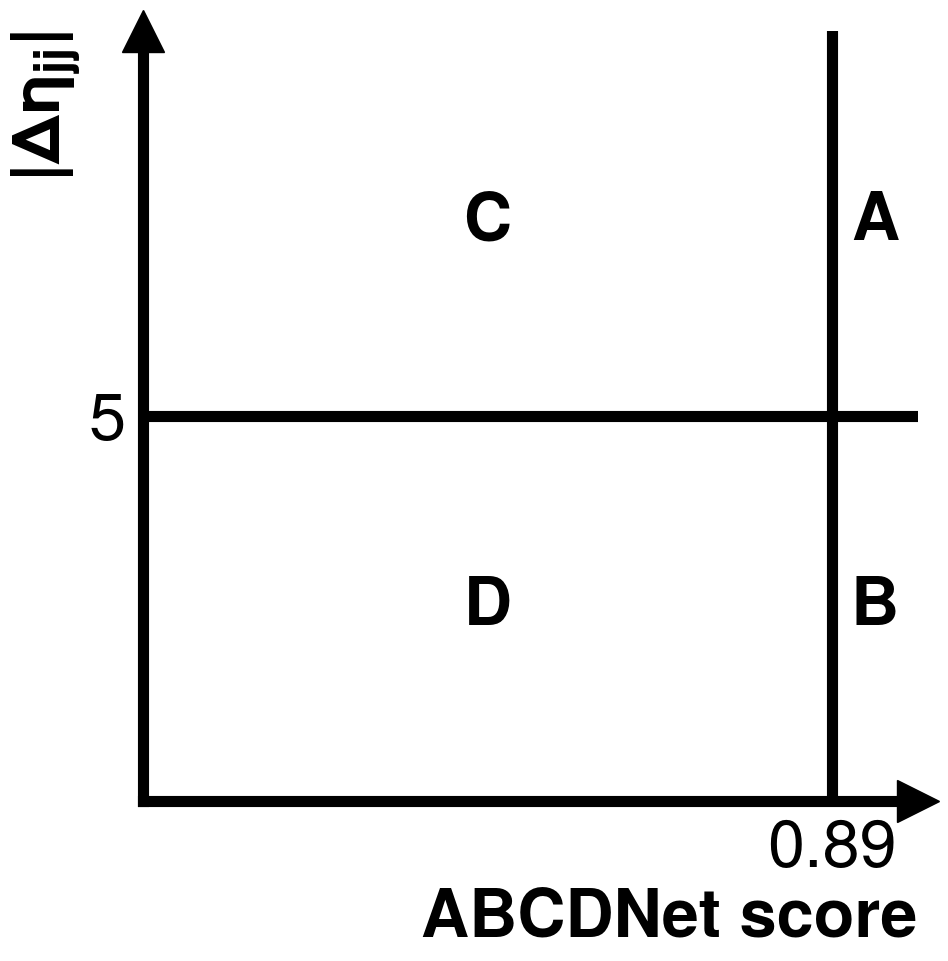

In [219]:
plot_abcd_cartoon(x_arm, y_arm)

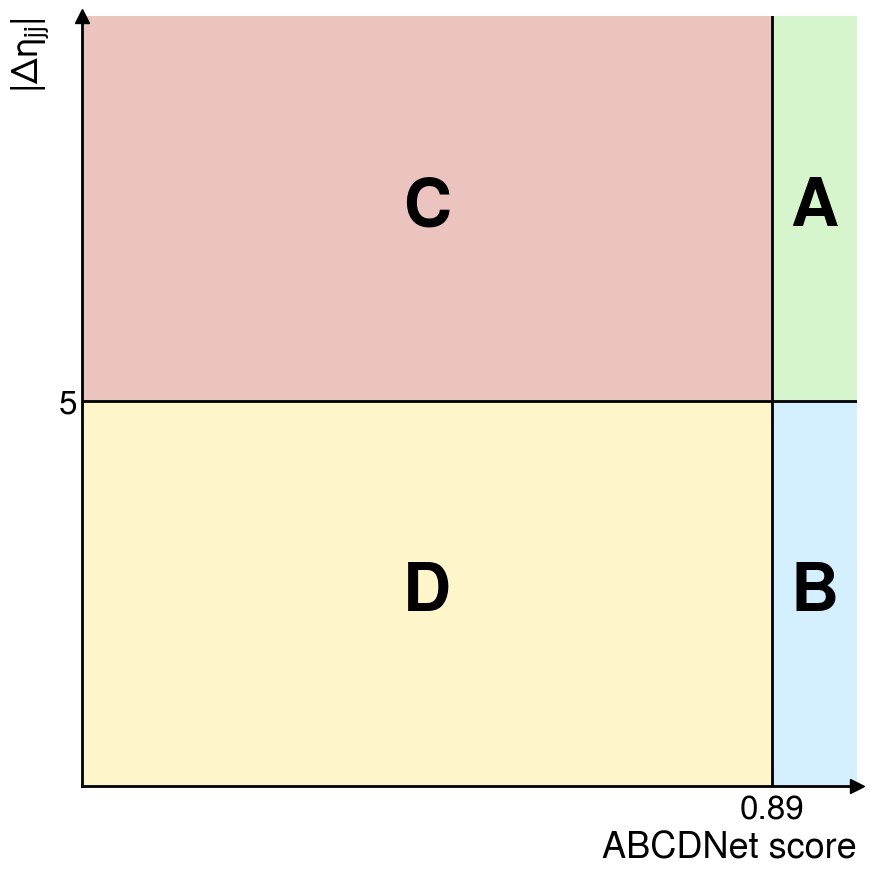

In [204]:
plot_abcd(x_arm, y_arm)

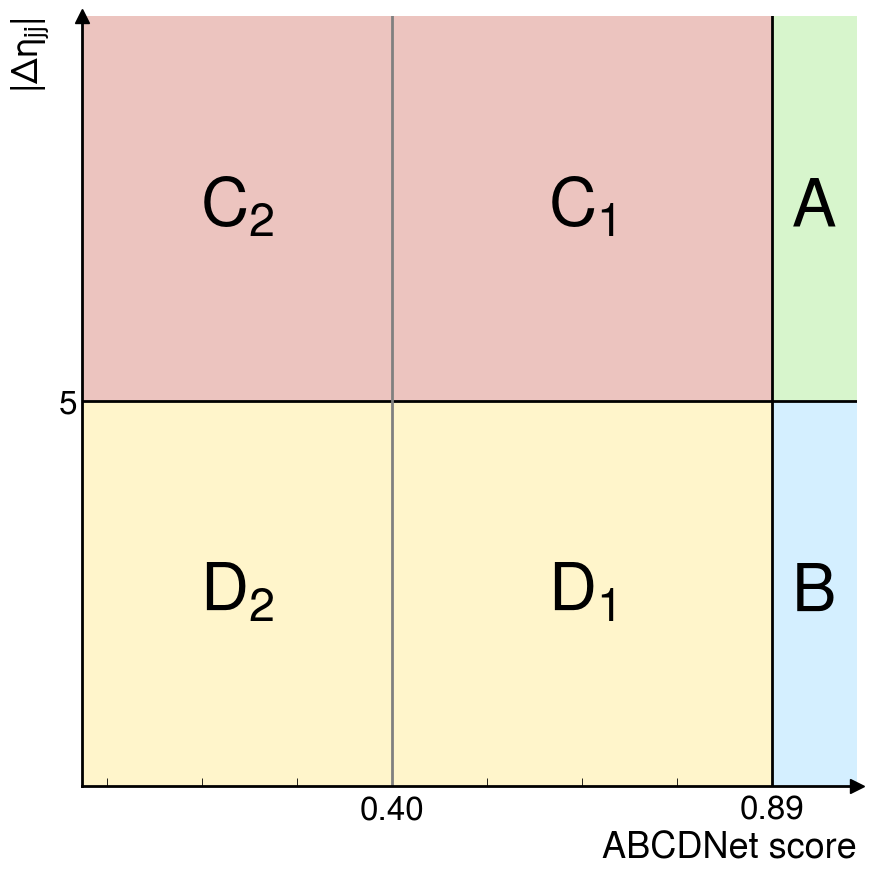

In [178]:
plot_abcd(x_arm, y_arm, x_mid=x_mid)

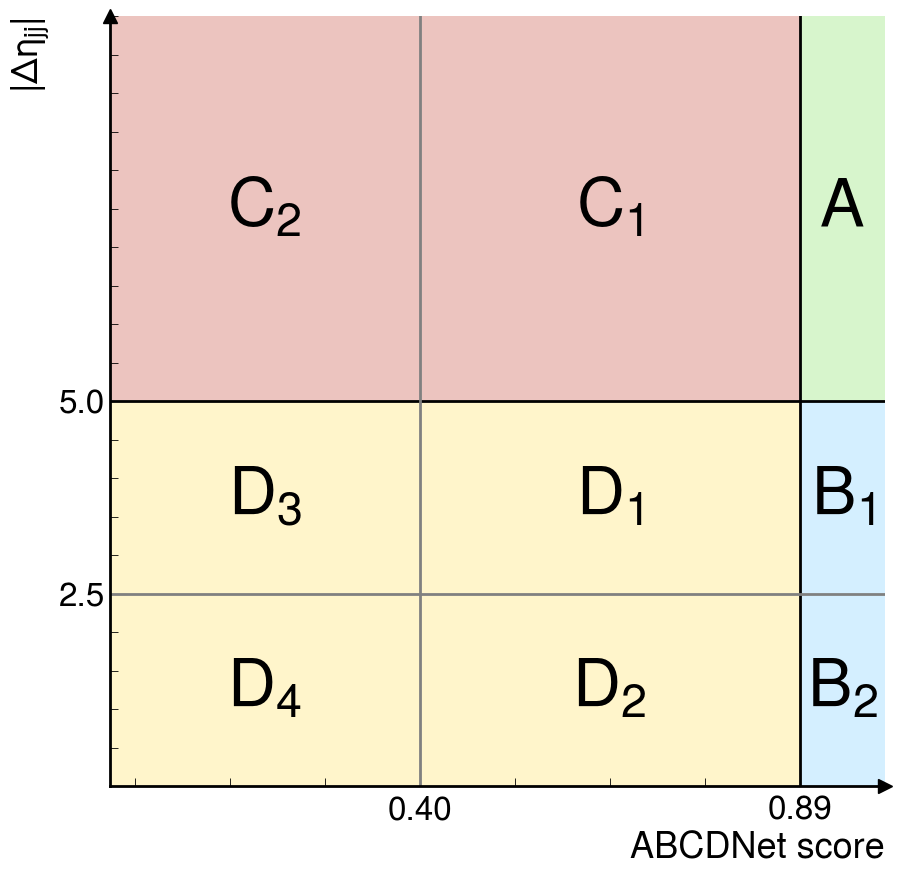

In [179]:
plot_abcd(x_arm, y_arm, x_mid=x_mid, y_mid=y_mid)

In [168]:
def get_abcd(A, B, C, D):
    mc_pred_A_count = 0
    mc_pred_A_error = 0
    data_pred_A_count = 0
    data_pred_A_error = 0
    show_data = False
    print(f"{'bkg':>10},{'bkg err':>10},{'sig':>10},{'sig err':>10},{'data':>10},{'data err':>10}")
    for region_i, region in enumerate([A, B, C, D]):
        # MC counts
        sig_count, bkg_count = vbsvvh.get_event_counts(selection=region)
        sig_error, bkg_error = vbsvvh.get_event_errors(selection=region)
        csv_line = f"{bkg_count:>10.4f},{bkg_error:>10.4f},{sig_count:>10.4f},{sig_error:>10.4f}"
        # Data counts
        data_count = vbsvvh.data_count(selection=region)
        data_error = vbsvvh.data_error(selection=region)
        if sig_count < bkg_error and sig_count < bkg_count*0.1:
            csv_line += f",{data_count:>10.4f},{data_error:>10.4f}"
            show_data = True
        else:
            csv_line += f",    —     ,    —     "
        print(csv_line)
        # Do extrapolation
        if region_i == 1:
            mc_pred_A_count = bkg_count
            data_pred_A_count = data_count
        elif region_i == 2:
            mc_pred_A_count *= bkg_count
            data_pred_A_count *= data_count
        elif region_i == 3 and bkg_count > 0:
            mc_pred_A_count /= bkg_count
            data_pred_A_count /= data_count
        # Calculate error
        if region_i > 0 and bkg_count > 0:
            mc_pred_A_error += (bkg_error/bkg_count)**2
            data_pred_A_error += 1/data_count
    
    mc_pred_A_error = np.sqrt(mc_pred_A_error)*mc_pred_A_count
    data_pred_A_error = np.sqrt(data_pred_A_error)*data_pred_A_count
    print()
    print(f"MC pred_A_count = {mc_pred_A_count:.2f}")
    print(f"MC pred_A_error = {mc_pred_A_error:.2f}")
    print(f"Data pred_A_count = {data_pred_A_count:.2f}")
    print(f"Data pred_A_error = {data_pred_A_error:.2f}")
    print()

In [9]:
print("A = B*C/D:")
get_abcd(A, B, C, D)

print("B1 = B2*D1/D2:")
get_abcd(B1, B2, D1, D2)

print("D1 = D2*D3/D4:")
get_abcd(D1, D2, D3, D4)

print("C1 = D1*C2/D3:")
get_abcd(C1, D1, C2, D3)

print("---\n")

print("A = B*C1'/D1':")
get_abcd(A, B, C1, f"({D1}) or ({D2})")

print("C1 = D1'*C2/D2':")
get_abcd(C1, f"({D1}) or ({D2})", C2, f"({D3}) or ({D4})")

A = B*C/D:
       bkg,   bkg err,       sig,   sig err,      data,  data err
    2.3718,    0.8516,    5.1389,    0.0684,    —     ,    —     
   11.5932,    1.8344,    0.9649,    0.0301,   10.0000,    3.1623
   62.0771,   12.4965,    0.3958,    0.0187,   72.0000,    8.4853
  634.9395,   35.6055,    0.3293,    0.0166,  677.0000,   26.0192

MC pred_A_count = 1.13
MC pred_A_error = 0.30
Data pred_A_count = 1.06
Data pred_A_error = 0.36

B1 = B2*D1/D2:
       bkg,   bkg err,       sig,   sig err,      data,  data err
    5.0094,    0.9898,    0.4856,    0.0211,    3.0000,    1.7321
    6.5838,    1.5445,    0.4792,    0.0214,    7.0000,    2.6458
   37.0860,   10.5200,    0.0978,    0.0089,   28.0000,    5.2915
   53.8756,   12.1739,    0.1490,    0.0115,   34.0000,    5.8310

MC pred_A_count = 4.53
MC pred_A_error = 1.96
Data pred_A_count = 5.76
Data pred_A_error = 2.63

D1 = D2*D3/D4:
       bkg,   bkg err,       sig,   sig err,      data,  data err
   37.0860,   10.5200,    0.0978,    